In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random, time

In [3]:
# Load data
data = pd.read_csv("income.csv")

cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'education-num', 'hours-per-week']
label_col = 'label'


In [4]:
# Encode categoricals
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Encode label
le_target = LabelEncoder()
data[label_col] = le_target.fit_transform(data[label_col])

In [5]:
# Split
X_cats = data[cat_cols].values
X_conts = data[cont_cols].values
y = data[label_col].values

cat_train, cat_test, con_train, con_test, y_train, y_test = train_test_split(
    X_cats, X_conts, y, test_size=5000, train_size=25000, random_state=42
)

# Scale continuous
scaler = StandardScaler()
con_train = scaler.fit_transform(con_train)
con_test = scaler.transform(con_test)

# Convert to tensors
cat_train = torch.tensor(cat_train, dtype=torch.int64)
cat_test  = torch.tensor(cat_test, dtype=torch.int64)
con_train = torch.tensor(con_train, dtype=torch.float)
con_test  = torch.tensor(con_test, dtype=torch.float)
y_train   = torch.tensor(y_train, dtype=torch.long)
y_test    = torch.tensor(y_test, dtype=torch.long)

In [6]:
class TabularModel(nn.Module):
    def __init__(self, emb_dims, n_cont, out_sz, hidden_layers=50, p=0.4):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_dims])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        self.fc1 = nn.Linear(sum([nf for ni,nf in emb_dims])+n_cont, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, out_sz)
        self.dropout = nn.Dropout(p)

    def forward(self, x_cats, x_conts):
        embeddings = [e(x_cats[:,i]) for i,e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_conts = self.bn_cont(x_conts)
        x = torch.cat([x, x_conts], 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

emb_dims = [(len(data[col].unique()), min(50, (len(data[col].unique())+1)//2)) for col in cat_cols]
model = TabularModel(emb_dims, len(cont_cols), out_sz=2, hidden_layers=50, p=0.4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
epochs = 300
losses = []

start_time = time.time()
for i in range(epochs):
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    if i % 25 == 0:
        print(f"Epoch {i} Loss: {loss.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print(f"Training took {duration/60:.2f} minutes")

Epoch 0 Loss: 0.6824
Epoch 25 Loss: 0.5213
Epoch 50 Loss: 0.4531
Epoch 75 Loss: 0.4066
Epoch 100 Loss: 0.3767
Epoch 125 Loss: 0.3599
Epoch 150 Loss: 0.3488
Epoch 175 Loss: 0.3384
Epoch 200 Loss: 0.3295
Epoch 225 Loss: 0.3200
Epoch 250 Loss: 0.3156
Epoch 275 Loss: 0.3085
Training took 0.41 minutes


In [9]:
with torch.no_grad():
    y_test_pred = model(cat_test, con_test)
    test_loss = criterion(y_test_pred, y_test)
    y_test_class = torch.argmax(y_test_pred, dim=1)
    acc = (y_test_class == y_test).float().mean()

print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {acc.item()*100:.2f}%")

Test Loss: 0.3023
Test Accuracy: 85.66%


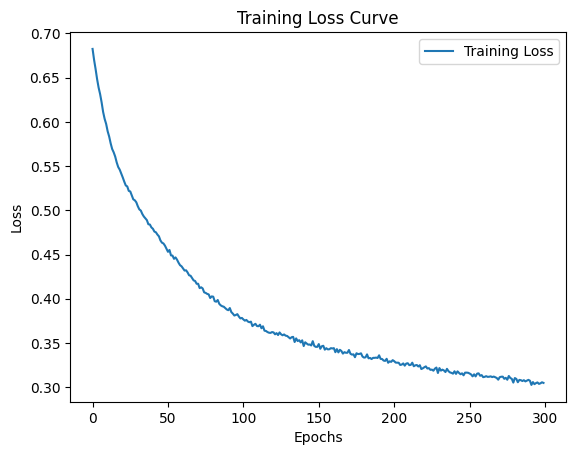

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [11]:
losses = []
test_accuracies = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on test set
    with torch.no_grad():
        y_pred_test = model(cat_test, con_test)
        y_pred_classes = torch.argmax(y_pred_test, dim=1)
        acc = (y_pred_classes == y_test).sum().item() / len(y_test)
        test_accuracies.append(acc)

    # Print progress
    if i % 25 == 1:
        print(f'Epoch: {i}, Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}')

Epoch: 1, Loss: 0.3067, Test Accuracy: 0.8576
Epoch: 26, Loss: 0.3001, Test Accuracy: 0.8534
Epoch: 51, Loss: 0.2987, Test Accuracy: 0.8598
Epoch: 76, Loss: 0.2977, Test Accuracy: 0.8578
Epoch: 101, Loss: 0.2932, Test Accuracy: 0.8618
Epoch: 126, Loss: 0.2928, Test Accuracy: 0.8638
Epoch: 151, Loss: 0.2852, Test Accuracy: 0.8702
Epoch: 176, Loss: 0.2883, Test Accuracy: 0.8666
Epoch: 201, Loss: 0.2850, Test Accuracy: 0.8660
Epoch: 226, Loss: 0.2840, Test Accuracy: 0.8692
Epoch: 251, Loss: 0.2858, Test Accuracy: 0.8700
Epoch: 276, Loss: 0.2843, Test Accuracy: 0.8702


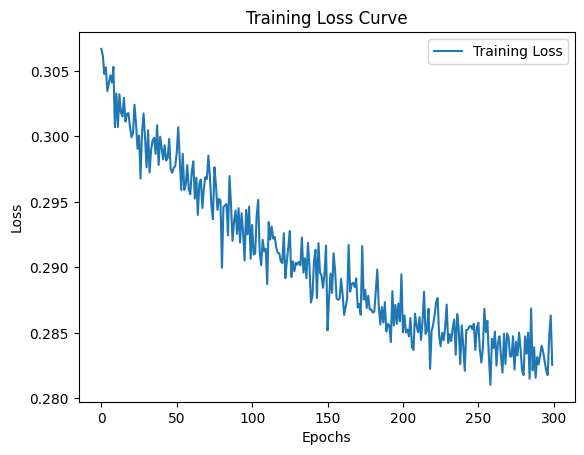

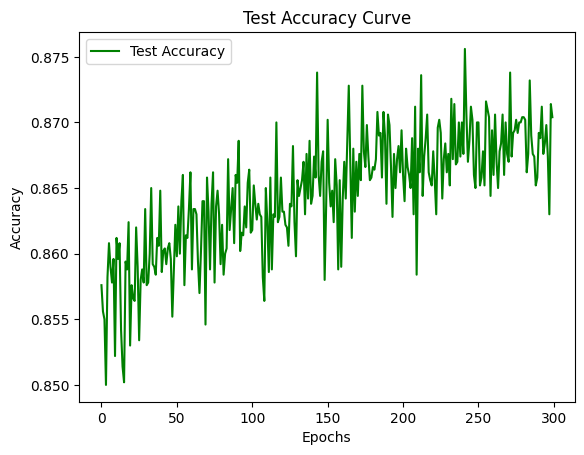

In [12]:
# Loss curve
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# Accuracy curve
plt.plot(test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Curve")
plt.legend()
plt.show()
